In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import sys
import scipy
import math
import scipy.stats as st
import pyslsqp 
%matplotlib inline

In [62]:
stocks_df = pd.read_csv('./sp500_stocks.csv')

prices_df = stocks_df.pivot(index='Date', columns='Symbol', values='Close')
prices_df = prices_df.dropna(axis=1)  # remove stocks with missing prices

tickers = prices_df.columns.tolist()

# randomly select 50 assets
np.random.seed(0)
selected_assets = np.random.choice(tickers, size=50, replace=False)

prices = prices_df[selected_assets]

tickers = prices.columns.tolist()

In [63]:
def compute_returns(prices, time):
    """
    computes log returns and expected returns over a specified time horizon.

    Parameters:
    - prices (DataFrame): Stock prices with dates as rows and symbols as columns.
    - time (int): Number of trading days to scale the expected returns.

    Returns:
    - returns (DataFrame): Daily log returns for each stock.
    - e_returns (Series): Expected returns scaled over the input time 
    """
    # log returns
    returns = np.log(prices / prices.shift(1)).dropna()
    
    # arithmetic returns
    #returns = prices.pct_change().dropna()
    
    daily_mean_returns = returns.mean()
    e_returns = daily_mean_returns * time
    
    return returns, e_returns

In [66]:
###################################################################################
# COMPUTE ESTIMATE COVARIANCE MATRIX
###################################################################################
def build_estimate_covariance_matrix(returns, time):
    """
    builds the estimated covariance matrix of asset returns, scaled over time

    Parameters:
    - returns (DataFrame): Daily returns for each asset.
    - time (int): Scaling factor (number of trading days)

    Returns:
    - (ndarray): Covariance matrix (scaled by time)
    """
    return returns.cov().to_numpy()*time

In [68]:
###################################################################################
# FIND EFFICIENT PORTFOLIO
###################################################################################
# Allow shorting, analytical solution is usually more efficient than numerical
#def efficient_portfolio(sigma):
#    inverse_sigma = np.linalg.inv(sigma)
#    dim = len(inverse_sigma)
#    ones = np.ones(dim)
#    return (np.dot(inverse_sigma, ones))/(np.dot(np.dot(ones.T, inverse_sigma), ones))

# No-shorting rule
# To calulcate the efficient portfolio, we employ the numerical solver
# PySLSQP, which is documented here: 
def efficient_portfolio(mu, cov_matrix, mu_target):
    """
    solves for the weights of an efficient portfolio given a return target

    Parameters:
    - mu (ndarray): Expected returns vector for each asset.
    - cov_matrix (ndarray): Covariance matrix of asset returns.
    - mu_target (float): Target expected return for the portfolio.

    Returns:
    - (ndarray): Optimal weights for the portfolio.
    """
    n = len(mu)
    mu = mu.reshape((n,))
    ones = np.ones(n)

    # Objective function: minimize portfolio variance
    def fun(x):
        return np.dot(x.T, np.dot(cov_matrix, x))
    
    # Gradient of the objective function
    def jac(x):
        return 2 * cov_matrix @ x

    # Constraints
    def c1(x):
        return np.dot(mu, x) - mu_target

    def c2(x):
        return np.sum(x) - 1

    def constraints(x):
        return np.array([c1(x), c2(x)])

    x0 = ones / n  # Initial guess

    # Solve
    result = pyslsqp.optimize(
        x0, 
        obj=fun, 
        grad=jac, 
        con=constraints,  
        xl=0, xu=1 # Non-negativity of weights + weights cannot be > 1
    )

    return result['x']

In [70]:
###################################################################################
# RUN SIMULATION EXAMPLE
###################################################################################
def run_experiment(prices, start_train, end_train, start_test, end_test):
    """
    runs an MVP optimization experiment with a training and testing phase.

    Parameters:
    - prices (DataFrame): Price data for the assets.
    - start_train, end_train (int): Training date indices.
    - start_test, end_test (int): Testing date indices.

    Returns:
    - (dict): Portfolio performance metrics including weights, return, variance, and Sharpe ratio.
    """
    num_stocks = prices.shape[1]
    n = end_train - start_train
    m = end_test - start_test

    # increase to penalize risk more
    risk_free_rate = np.log(1.04) * (m/252)  # r = log(1 + annual_rate)*(time/252)
    
    # returns and expected returns
    ret, mu = compute_returns(prices.iloc[start_train:end_train], n)
    ret_test, mu_test = compute_returns(prices.iloc[start_test:end_test], m)
    
    # estimate covariance matrix
    estimate_covariance = build_estimate_covariance_matrix(ret, n)
    covariance_test = build_estimate_covariance_matrix(ret_test, m)
    
    # portfolios
    MVP = efficient_portfolio(mu.to_numpy(), estimate_covariance, 0.25) # Target high return rate
    Control = np.ones(num_stocks) / num_stocks
    
    MVP_return = np.dot(mu_test, MVP)
    Control_return = np.dot(Control, mu_test)
    
    MVP_cov = np.dot(np.dot(MVP.T, covariance_test), MVP)
    Control_cov = np.dot(np.dot(Control.T, covariance_test), Control)
    

    MVP_sharpe = (MVP_return - risk_free_rate) / math.sqrt(MVP_cov)
    Control_sharpe = (Control_return - risk_free_rate) / math.sqrt(Control_cov)

    metrics = {'MVP Weights': MVP,
               'Control Weights': Control,
               'MVP Return' : MVP_return, 
               'Control Return': Control_return,
               'MVP Cov' : MVP_cov,
               'Control Cov': Control_cov,
               'MVP Sharpe': MVP_sharpe,
               'Control Sharpe': Control_sharpe}
    return metrics

Optimization terminated successfully    (Exit mode 0)
            Final objective value                : 2.693004e-02
            Final optimality                     : 6.456094e-07
            Final feasibility                    : 1.064315e-12
            Number of major iterations           : 18
            Number of function evaluations       : 18
            Number of derivative evaluations     : 18
            Average Function evaluation time     : 0.000053 s per evaluation
            Average Derivative evaluation time   : 0.000531 s per evaluation
            Total Function evaluation time       : 0.000950 s [  0.87%]
            Total Derivative evaluation time     : 0.009566 s [  8.78%]
            Optimizer time                       : 0.015061 s [ 13.82%]
            Processing time                      : 0.083370 s [ 76.52%]
            Visualization time                   : 0.000000 s [  0.00%]
            Total optimization time              : 0.108946 s [100.00%]
      

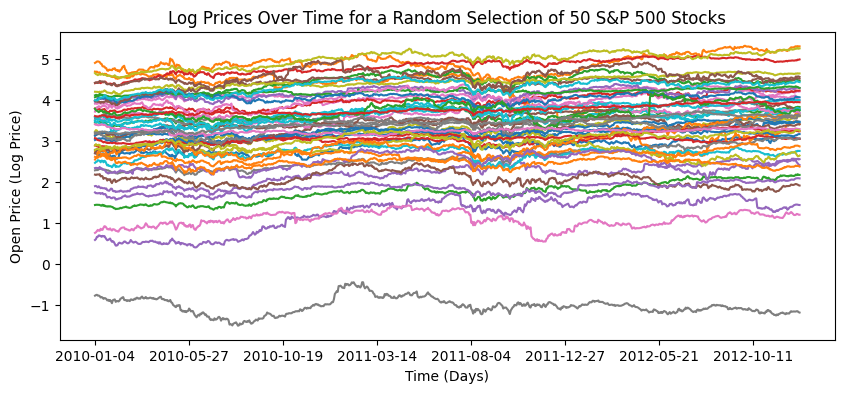

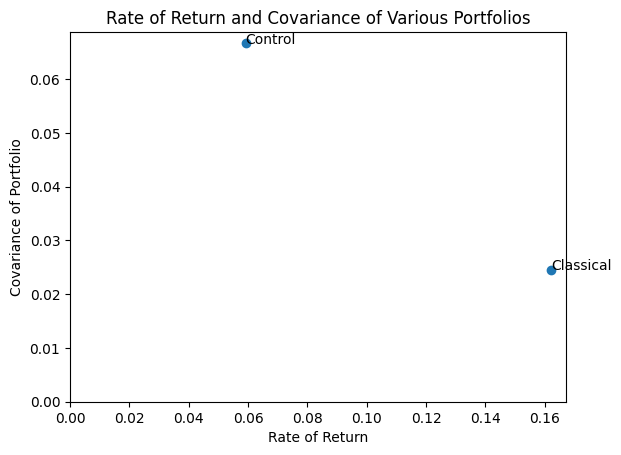

In [72]:
# Display example experiment results
# Using 50 stocks, training on the first 400 days of data
# Testing on subsequent 200 days of data
results = run_experiment(prices, 0, 400, 400, 600)

print("\n")
print("Portfolio Weights:")
print(results['MVP Weights'])
print(results['Control Weights'])
print("\n")

print("Return Classical: ", results['MVP Return'])
print("Return Control: ", results['Control Return'])
print("\n")

print("Variance Classical: ", results['MVP Cov'])
print("Variance Control: ", results['Control Cov'])
print("\n")

print("Sharpe Ratio Classical: ", results['MVP Sharpe'])
print("Sharpe Ratio Control: ", results['Control Sharpe'])

# Plot prices for the first 750 days
np.log(prices.iloc[0:750]).plot(figsize=(10, 4), legend=False)
plt.xlabel("Time (Days)")
plt.ylabel("Open Price (Log Price)")
plt.title("Log Prices Over Time for a Random Selection of 50 S&P 500 Stocks")

x = [results['MVP Return'], results['Control Return']]
y = [results['MVP Cov'], results['Control Cov']]
labels = ["Classical", "Control"]
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.xlabel("Rate of Return")
plt.ylabel("Covariance of Portfolio")
plt.title("Rate of Return and Covariance of Various Portfolios")

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    #ax.set_ylim(top=0.01)
    #ax.set_xlim(right=0.25)
plt.show()